In [1]:
!nvidia-smi

Thu Dec 14 10:45:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 34%   48C    P5    44W / 320W |   7742MiB / 10240MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install transformers

In [3]:
# from google.colab import drive
# drive.mount("/content/drive")

In [4]:
# cd /content/drive/MyDrive/secBertClassifier/

In [5]:
import pandas as pd
import os
import numpy as np
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score

from transformers import AutoTokenizer, BertModel, BertTokenizer

from tqdm import tqdm

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
#config
CHUNK = 3
CHUNK_SIZE = 512
MAX_LENGTH = CHUNK_SIZE*CHUNK
PRE_MODEL = "jackaduma/SecBERT"
TRAIN_BATCH_SIZE = 4
LABELS = 4

In [8]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

In [9]:
#load model
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=PRE_MODEL)
model_bert = BertModel.from_pretrained(pretrained_model_name_or_path=PRE_MODEL)

In [10]:
FREEZE_LAYER = 5
for param in model_bert.encoder.layer[0:FREEZE_LAYER].parameters():
    param.requires_grad = False

In [11]:
data_folder = os.getcwd()+"/secBertClassifier/Untitled Folder"

X_train_df = pd.read_csv(f'{data_folder}/X_train.csv')
y_train_df = pd.read_csv(f'{data_folder}/y_train.csv')
X_val_df = pd.read_csv(f'{data_folder}/X_val.csv')
y_val_df = pd.read_csv(f'{data_folder}/y_val.csv')
X_test_df = pd.read_csv(f'{data_folder}/X_test.csv')
y_test_df = pd.read_csv(f'{data_folder}/y_test.csv')

In [12]:
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_val = X_val_df.to_numpy()
y_val = y_val_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

In [13]:
y_val[0]

array([0, 1, 1, 0])

In [14]:
class CustomClassifier(nn.Module):
    def __init__(self, num_class, in_features):
        super(CustomClassifier, self).__init__()

        self.clf1 = nn.Linear(in_features,768)
        self.clf2 = nn.Linear(768, 256)
        self.clf3 = nn.Linear(256,num_class)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output = self.clf1(x)
        output = self.clf2(output)
        output = self.clf3(output)
        output = self.sigmoid(output)
        return output

In [15]:
class OpcodeData(Dataset):
    def __init__(self, X, y, tokenizer, max_len, num_of_chunk):
        self.tokenizer = tokenizer
        self.X = X
        self.targets = y
        self.max_len = max_len
        self.num_of_chunk = num_of_chunk

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        text = str(self.X[index])

        inputs = self.tokenizer(
            text,
            None,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            max_length=self.max_len
        )

        ids = inputs['input_ids']
        masks = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        new_ids = []
        new_masks = []
        new_token_types = []

        for i in range(self.num_of_chunk):
            new_ids.append(ids[(512*i): (512*i+512)])
            new_masks.append(masks[(512*i):(512*i+512)])
            new_token_types.append(token_type_ids[(512*i):(512*i+512)])

        return {
            'ids': torch.tensor(new_ids, dtype=torch.long),
            'masks': torch.tensor(new_masks, dtype=torch.long),
            'token_type_ids': torch.tensor(new_token_types, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [16]:
training_set = OpcodeData(X_train,y_train,tokenizer,MAX_LENGTH,CHUNK)
val_set = OpcodeData(X_val,y_val,tokenizer,MAX_LENGTH,CHUNK)
test_set = OpcodeData(X_test,y_test,tokenizer,MAX_LENGTH,CHUNK)

In [17]:
training_set[0]

{'ids': tensor([[ 2, 37, 11,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]]),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'targets': tensor([0., 0., 1., 0.])}

In [18]:
training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE)
validating_loader = DataLoader(val_set, batch_size=TRAIN_BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=TRAIN_BATCH_SIZE)

In [19]:
import matplotlib.pyplot as plt

def plot_graph(train, val, epoch, title):
    fig = plt.figure(figsize=(12,12))
    plt.title(title)
    plt.plot(list(np.arange(epoch) + 1) , train, label='train')
    plt.plot(list(np.arange(epoch) + 1), val, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    # plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.savefig(f'result/{title}.png')

In [20]:
def train_steps(train_loader: DataLoader, model_bert, model_classifier, loss_f, optimizer, num_of_chunk, **kwargs):
    print("Training ...")
    train_loss = 0
    train_acc = 0
    steps = 0

    model_bert.train()
    model_classifier.train()

    for step, batch in enumerate(tqdm(train_loader)):

        optimizer.zero_grad()

        labels = batch['targets'].to(device)
        ids = batch['ids'].to(device)
        masks = batch['masks'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)

        features = []

        for i in range(num_of_chunk):
            sub_ids = ids[:,i,:]
            sub_masks = masks[:,i,:]
            sub_token_types = token_type_ids[:,i,:]

            feature = model_bert(input_ids=sub_ids, attention_mask=sub_masks, token_type_ids=sub_token_types)

            feature = feature.pooler_output

            features.append(feature)

        new_features = torch.cat(features, dim=1)

        new_features = new_features.view(new_features.size(0), -1)
        preds = model_classifier(new_features)

        loss = loss_f(preds, labels)

        label_pred = preds.detach().cpu().numpy()
        label_pred = np.where(label_pred>=0.5, 1, 0)
        label_true = labels.to('cpu').numpy()
        acc = accuracy_score(label_true, label_pred)

        train_acc += acc
        train_loss += loss.item()
        steps += 1

        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model_bert.parameters(), 1.0)
        optimizer.step()

    epoch_loss = train_loss / steps
    epoch_acc = train_acc / steps

    return epoch_loss, epoch_acc

In [21]:
def evaluate_steps(validating_loader, model_bert, model_classifier, loss_f, num_of_chunk):
    print("\nEvaluating...")

    # deactivate dropout layers
    model_bert.eval()
    model_classifier.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []

    for step, batch in enumerate(tqdm(validating_loader)):

        b_input_ids = batch['ids'].to(device)
        b_input_mask = batch['masks'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        b_labels = batch['targets'].to(device)

        # deactivate autograd
        with torch.no_grad():
            # model predictions
            features = []

            for i in range(num_of_chunk):
                sub_ids = b_input_ids[:,i,:]
                sub_masks = b_input_mask[:,i,:]
                sub_token_types = token_type_ids[:,i,:]

                feature = model_bert(input_ids=sub_ids, attention_mask=sub_masks, token_type_ids=sub_token_types)

                feature = feature.pooler_output

                features.append(feature)

            new_features = torch.cat(features, dim=1)
            new_features = new_features.view(new_features.size(0), -1)
            preds = model_classifier(new_features)
            # print('pass')

            # compute the validation loss
            loss = loss_f(preds, b_labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            preds = np.where(preds>=0.5, 1, 0)
            total_preds += list(preds)
            total_labels += b_labels.tolist()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(validating_loader)
    acc_score = accuracy_score(total_labels, total_preds)

    return avg_loss, acc_score


In [22]:
def predict(testing_loader, model_bert, model_classifier, num_of_chunk):
    print("\nEvaluating...")
    # deactivate dropout layers
    model_bert.eval()
    model_classifier.eval()

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step, batch in enumerate(tqdm(testing_loader)):
        # push the batch to gpu
        b_input_ids = batch['ids'].to(device)
        b_input_mask = batch['masks'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        b_labels = batch['targets'].to(device)

        # deactivate autograd
        with torch.no_grad():
          # model predictions
          features = []

          for i in range(num_of_chunk):
              sub_ids = b_input_ids[:,i,:]
              sub_masks = b_input_mask[:,i,:]
              sub_token_types = token_type_ids[:,i,:]

              feature = model_bert(input_ids=sub_ids, attention_mask=sub_masks, token_type_ids=sub_token_types)

              feature = feature.pooler_output

              features.append(feature)

          new_features = torch.cat(features, dim=1)
          new_features = new_features.view(new_features.size(0), -1)
          preds = model_classifier(new_features)

          preds = preds.detach().cpu().numpy()
          preds = np.where(preds>=0.5, 1, 0)
          total_preds += list(preds)
          total_labels += b_labels.tolist()

    return total_preds, total_labels


In [23]:
def train(epochs, model_bert, model_classifier, optimizer, criterion, dataloader, num_of_chunk):
  data_train_loader, data_val_loader = dataloader
  # set initial loss to infinite
  best_valid_loss = float('inf')
  train_losses = []
  valid_losses = []
  train_accuracies = []
  valid_accuracies = []

  for epoch in range(epochs):
    print('Epoch {}/{} '.format(epoch + 1, epochs))
    start_time = time.time()
    train_loss, train_acc = train_steps(data_train_loader, model_bert, model_classifier, criterion, optimizer, num_of_chunk)

    valid_loss, valid_acc = evaluate_steps(data_val_loader, model_bert, model_classifier, criterion, num_of_chunk)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_bert.state_dict(), 'secbert.pt')
        torch.save(model_classifier.state_dict(), 'classifier.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    elapsed_time = time.time() - start_time

    print('loss={:.4f} \t accuracy={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(train_loss, train_acc, valid_loss, valid_acc, elapsed_time))
  return train_accuracies, valid_accuracies, train_losses, valid_losses

In [24]:
EPOCHS = 10
LEARNING_RATE = 1e-04
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(params = model_bert.parameters(), lr=LEARNING_RATE, weight_decay=0.01, amsgrad=False)

model_classifier = CustomClassifier(num_class=4, in_features=768*CHUNK)

In [25]:
model_bert.to(device)
model_classifier.to(device)

CustomClassifier(
  (clf1): Linear(in_features=2304, out_features=768, bias=True)
  (clf2): Linear(in_features=768, out_features=256, bias=True)
  (clf3): Linear(in_features=256, out_features=4, bias=True)
  (sigmoid): Sigmoid()
)

In [26]:
train_acc, val_acc, train_loss, val_loss = train(EPOCHS, model_bert, model_classifier, optimizer, criterion, (training_loader, validating_loader), CHUNK)

Epoch 1/10 
Training ...


  0%|          | 0/30570 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacty of 9.77 GiB of which 41.75 MiB is free. Process 78447 has 7.15 GiB memory in use. Including non-PyTorch memory, this process has 2.14 GiB memory in use. Of the allocated memory 1.13 GiB is allocated by PyTorch, and 23.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

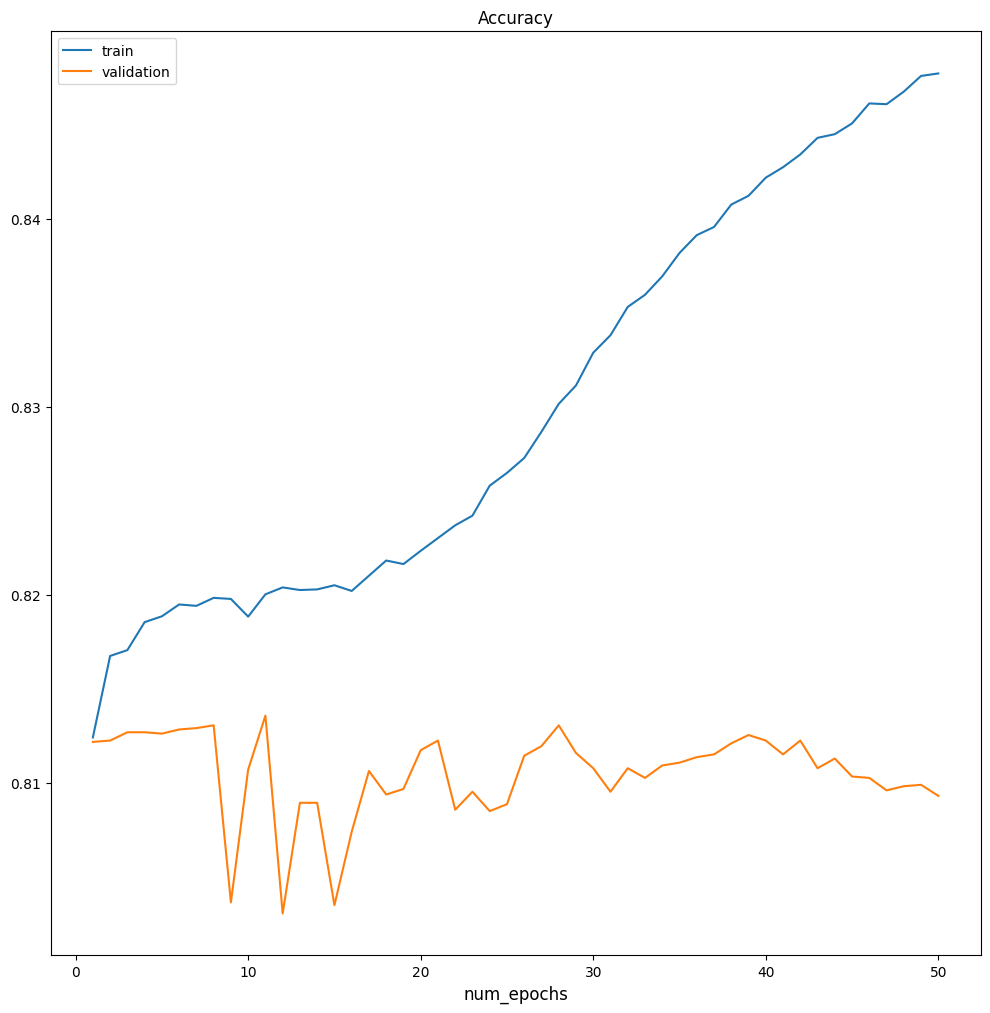

In [ ]:
plot_graph(train_acc, val_acc,EPOCHS ,"Accuracy")

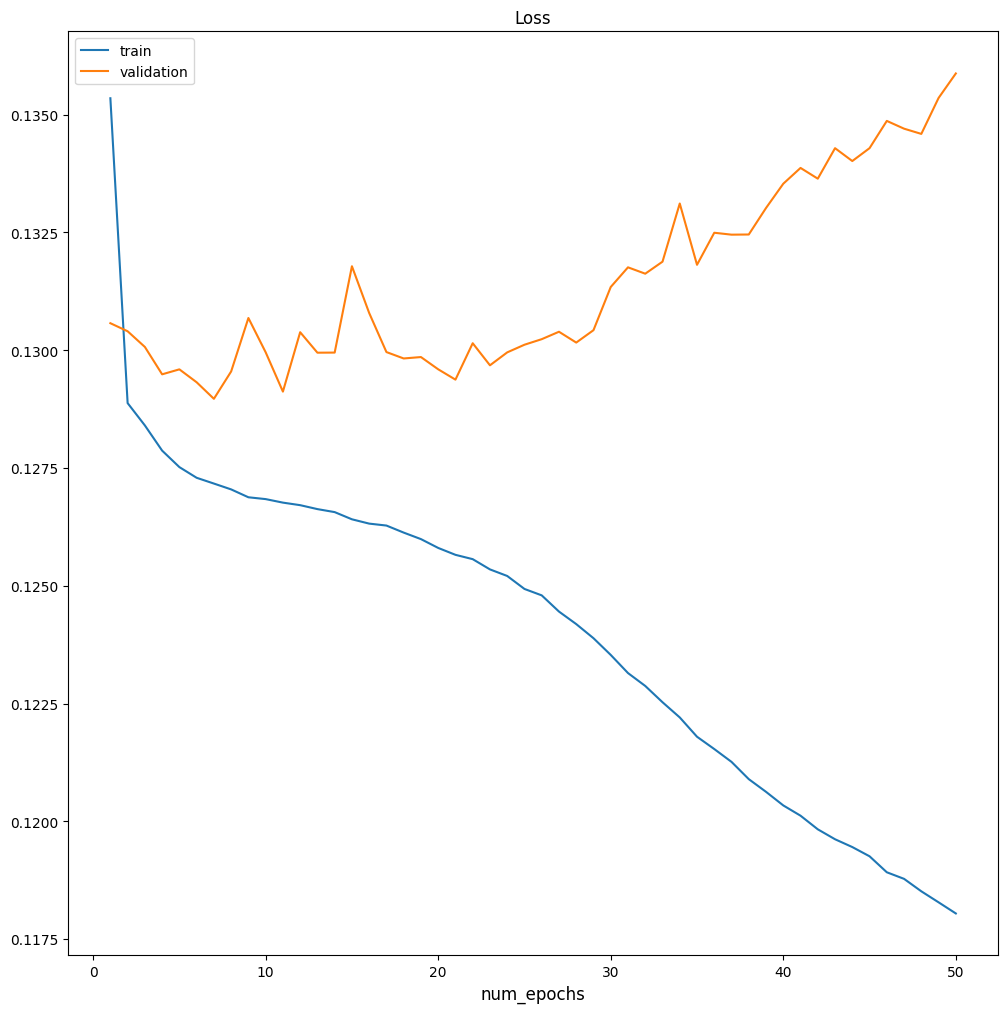

In [ ]:
plot_graph(train_loss, val_loss,EPOCHS ,"Loss")

In [ ]:
# total_preds, total_labels = predict(test_loader, model_bert, model_classifier, CHUNK)

# acc = accuracy_score(total_labels, total_preds)
# print(acc)


Evaluating...


100%|██████████| 4246/4246 [12:15<00:00,  5.77it/s]

0.8124944799364089


In [ ]:
# torch.save(model_bert.state_dict(), 'secbert_last.pt')
# torch.save(model_classifier.state_dict(), 'classifier_last.pt')

In [ ]:
model_bert.load_state_dict(torch.load('secbert.pt'))
model_classifier.load_state_dict(torch.load('classifier.pt'))
total_preds, total_labels = predict(test_loader, model_bert, model_classifier, CHUNK)

acc = accuracy_score(total_labels, total_preds)
print(acc)


Evaluating...


100%|██████████| 4246/4246 [11:58<00:00,  5.91it/s]

0.8198840050637384


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
TARGETS = ['Timestamp dependence','Outdated Solidity version', 'Frozen Ether', 'Delegatecall Injection']

print(classification_report(total_labels, total_preds,target_names=TARGETS, digits=4))

                           precision    recall  f1-score   support

     Timestamp dependence     0.9982    0.9959    0.9971     10825
Outdated Solidity version     0.8453    0.9163    0.8794     23839
             Frozen Ether     0.9991    0.9989    0.9990     19610
   Delegatecall Injection     0.9949    0.9955    0.9952      7058

                micro avg     0.9357    0.9659    0.9505     61332
                macro avg     0.9594    0.9766    0.9677     61332
             weighted avg     0.9387    0.9659    0.9517     61332
              samples avg     0.9462    0.9670    0.9441     61332



/home/bkcs/miniconda3/envs/secbert/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bkcs/miniconda3/envs/secbert/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def accuracy(y_true, y_pred):
    temp = 0
    cnt = 0
    for i in range(y_true.shape[0]):
        up = sum(np.logical_and(y_true[i], y_pred[i]))
        down = sum(np.logical_or(y_true[i], y_pred[i]))
        if down != 0 :
            temp += up/down
            cnt += 1
        temp += 0
    return temp / cnt

def hamming_loss(y_true, y_pred):
    temp=0
    for i in range(y_true.shape[0]):
        temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
    return temp/(y_true.shape[0] * y_true.shape[1])

y_true = np.array(total_preds)
y_pred = np.array(total_labels)

In [ ]:
accuracy(y_true, y_pred)

0.9172907207579272

In [ ]:
hamming_loss(y_true, y_pred)

0.04537492271910972